# Example: Working with flow direction data

In this example we illustrate some common hydrology GIS problems based on so-called flow direction data. In HydroMT we make use of functionality from [pyflwdir](https://deltares.github.io/pyflwdir/latest/) to work with this type of data. HydroMT wraps some functionality of **pyflwdir**, to make it easier to work with [raster datasets](../guides/advanced_user/data_types.rst). However, pyflwdir has much more functionality. An overview of all the flow direction methods in HydroMT can be found in the [Reference API](../api/gis.rst#flow-direction-methods).

Here, we will showcase the following flow direction GIS cases:

1. Derive basin and stream geometries
2. Derive flow directions from elevation data
3. Reproject flow direction data
4. Upscale flow directions


In [1]:
from pprint import pprint

import geopandas as gpd

import hydromt
from hydromt.gis import utm_crs

First, we load some data to play with from the pre-defined artifact_data data catalog. For more information about working with data in HydroMT, see [the user guide](../guides/user_guide/data_overview.rst). As an example we will use the [MERIT Hydro](http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro) dataset which is set of GeoTiff files with identical grids, one for each variable of the datasets. We use the flow direction  (flwdir); elevation (elevtn) and upstream area (uparea) layers.

In [2]:
# initialize a data catalog based on the pre-defined artifact_data catalog
data_catalog = hydromt.DataCatalog(data_libs=["artifact_data=v1.0.0"])

# we load the flow direction  (flwdir); elevation (elevtn) and upstream area (uparea) layers
ds = data_catalog.get_rasterdataset(
    "merit_hydro",
    bbox=[11.7, 45.8, 12.8, 46.7],
    variables=["flwdir", "elevtn", "uparea"],
)
ds

object: ConventionResolver does not use kwarg mask with value                                             geometry
0  POLYGON ((12.8 45.8, 12.8 46.7, 11.7 46.7, 11.....


<xarray.Dataset> Size: 13MB
Dimensions:      (y: 1080, x: 1320)
Coordinates:
  * x            (x) float64 11kB 11.7 11.7 11.7 11.7 ... 12.8 12.8 12.8 12.8
  * y            (y) float64 9kB 46.7 46.7 46.7 46.7 ... 45.8 45.8 45.8 45.8
    spatial_ref  int64 8B 0
Data variables:
    flwdir       (y, x) uint8 1MB dask.array<chunksize=(1080, 1320), meta=np.ndarray>
    elevtn       (y, x) float32 6MB dask.array<chunksize=(1080, 1320), meta=np.ndarray>
    uparea       (y, x) float32 6MB dask.array<chunksize=(1080, 1320), meta=np.ndarray>
Attributes:
    crs:        4326
    category:   topography
    paper_doi:  10.1029/2019WR024873
    paper_ref:  Yamazaki et al. (2019)
    url:        http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_Hydro
    license:    CC-BY-NC 4.0 or ODbL 1.0

## Derive basin and stream geometries

If you have existing flow direction data from sources such as MERIT Hydro, or HydroSHEDS or similar, you can use these to delineate basins and extract streams based on a user-defined threshold. To do this we need to transform the gridded flow direction data into a `FlwdirRaster` object using the [flwdir_from_da()](../_generated/hydromt.gis.flw.flwdir_from_da.rst) method. This object is at the core of the **pyflwdir** package and creates an actionable common format from a flow direction raster which describes relations between cells.

NOTE: that for most methods a first call might be a bit slow as the numba code is compiled just in time, a second call of the same methods (also with different arguments) will be much faster!

In [3]:
# instantiate a FlwdirRaster object
flwdir = hydromt.gis.flw.flwdir_from_da(ds["flwdir"], ftype="d8")
print(type(flwdir))
print(flwdir)

<class 'pyflwdir.pyflwdir.FlwdirRaster'>


{'ftype': 'd8',
 'idxs_ds': array([      0,    1321,    1321, ..., 1425597, 1425598, 1425599],
      dtype=int32),
 'idxs_pit': array([      0,      41,      42, ..., 1425597, 1425598, 1425599],
      dtype=int32),
 'idxs_seq': None,
 'latlon': True,
 'nnodes': 1425600,
 'shape': (1080, 1320),
 'transform': Affine(np.float64(0.0008333333333333202), np.float64(0.0), np.float64(11.70000000000002),
       np.float64(0.0), np.float64(-0.0008333333333333327), np.float64(46.699999999999996))}


Next, we derive streams based on a 10 km2 upstream area threshold using the pyflwdir [streams](https://deltares.github.io/pyflwdir/latest/reference.html#pyflwdir.FlwdirRaster.streams) method. Pyflwdir returns a geojson like representation of the streams per stream segment, which we parse to a GeoPandas GeoDataFrame to easily plot it.

In [4]:
feats = flwdir.streams(
    mask=ds["uparea"].values > 10,
    strord=flwdir.stream_order(),  # set stream order property
    uparea=ds["uparea"].values,  # set upstream area property
)
gdf_riv = gpd.GeoDataFrame.from_features(feats, crs=ds.raster.crs)
pprint(gdf_riv.head())

                                            geometry     idx  idx_ds    pit  \
0  LINESTRING (12.72792 46.58375, 12.72708 46.582...  184713  220288  False   
1  LINESTRING (12.24458 46.55792, 12.24542 46.557...  225053  254104  False   
2  LINESTRING (12.23958 46.53542, 12.24042 46.536...  260687  254104  False   
3  LINESTRING (12.04542 46.56208, 12.04625 46.562...  218214  166785  False   
4  LINESTRING (12.03875 46.59708, 12.03958 46.597...  162766  166785  False   

   strord     uparea  
0       5  11.072655  
1       5  10.417005  
2       5  11.077365  
3       5  10.074309  
4       5  10.001467  


Using the [basin_map()](../_generated/hydromt.gis.flw.basin_map.rst) method we can delineate all basins in our domain.

In [5]:
# get the best utm zone CRS for a projected CRS
utm = utm_crs(ds.raster.bounds)
ds["basins"] = hydromt.gis.flw.basin_map(
    ds,
    flwdir,
)[0]
# use the  HydroMT "raster" data accessor to vectorize the basin raster.
gdf_bas = ds["basins"].raster.vectorize()
# calculate the area of each basin in the domain and sort the dataframe
gdf_bas["area"] = gdf_bas.to_crs(utm).area / 1e6  # km2
gdf_bas = gdf_bas.sort_values("area", ascending=False)
pprint(gdf_bas.head())

                                               geometry   value         area
1721  POLYGON ((12.445 46.69, 12.445 46.68917, 12.44...  2223.0  3963.680790
1906  POLYGON ((12.49917 46.41667, 12.49917 46.41583...  2399.0  1373.097681
1641  POLYGON ((11.79583 46.3075, 11.79583 46.30583,...  1604.0   479.056420
1724  POLYGON ((12.27083 45.99333, 12.27083 45.9925,...  2338.0   281.575903
990   POLYGON ((11.88667 46.7, 11.88667 46.69917, 11...   123.0   230.856916


Text(0.5, 1.0, 'Streams (darkblue) and basins (red)')

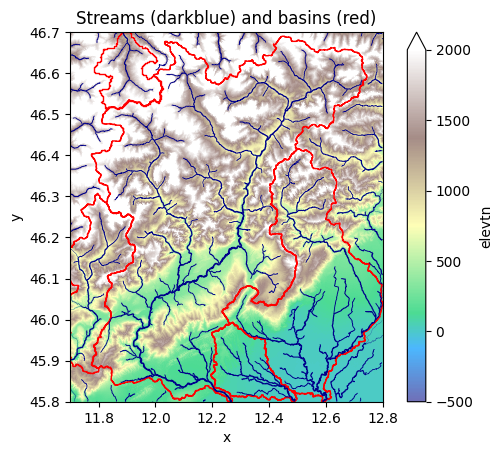

In [6]:
# plot the results
ax = gdf_bas[:5].boundary.plot(color="r", lw=1, zorder=2)
gdf_riv.plot(
    zorder=2,
    ax=ax,
    color="darkblue",
    lw=gdf_riv["strord"] / 8,
)
ds["elevtn"].plot(cmap="terrain", ax=ax, vmin=-500, vmax=2000, alpha=0.7)
ax.set_title("Streams (darkblue) and basins (red)")

## Derive flow directions from elevation data 

If you don't have flow direction data available these can be derived from an elevation raster. HydroMT implements the algorithm proposed by [Wang & Liu (2006)](https://www.tandfonline.com/doi/abs/10.1080/13658810500433453) to do this. We use the [d8_from_dem()](../_generated/hydromt.gis.flw.d8_from_dem.rst) method which wraps the pyflwdir [fill_depressions()](https://deltares.github.io/pyflwdir/latest/reference.html#pyflwdir.dem.fill_depressions) method. 

The derivation of flow direction can be aided by a river shape file with an upstream area ("uparea") property. Try uncommenting the `gdf_stream` argument and compare the results.

Text(0.5, 1.0, 'Original (darkblue) and new (red) streams')

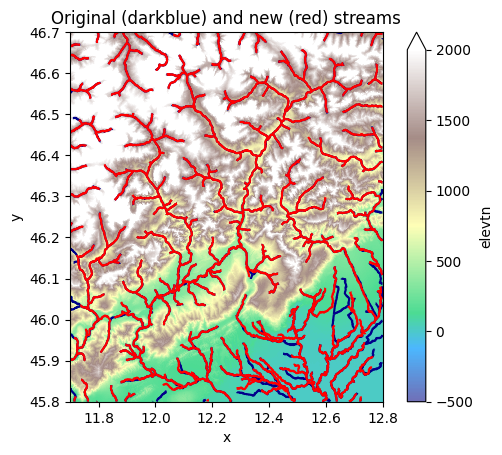

In [7]:
# derive flow directions raster from elevation
da_flw = hydromt.gis.flw.d8_from_dem(
    ds["elevtn"],
)
# parse it into a FlwdirRaster object
flwdir1 = hydromt.gis.flw.flwdir_from_da(da_flw, ftype="d8")
# derive streams based on a 10 km2 threshold
feats1 = flwdir1.streams(mask=flwdir1.upstream_area("km2") > 10)
gdf_riv1 = gpd.GeoDataFrame.from_features(feats1, crs=ds.raster.crs)

# plot the new streams  (red) and compare with the original (darkblue)
ax = gdf_riv.plot(zorder=2, color="darkblue")
gdf_riv1.plot(zorder=2, ax=ax, color="r")
ds["elevtn"].plot(cmap="terrain", ax=ax, vmin=-500, vmax=2000, alpha=0.7)
ax.set_title("Original (darkblue) and new (red) streams")

## Reproject flow direction data

Unlike continuous data such as elevation or data with discrete classes such as land use, flow direction data cannot simply be reclassified using common resampling methods. Instead, with the [reproject_hydrography_like()](../_generated/hydromt.gis.flw.reproject_hydrography_like.rst) a synthetic elevation grid is created based on an upstream area raster, this is reprojected and used to derive a new flow direction grid with the method described above. Note that this works well if we keep approximately the same resolution. For upscaling to larger grid cells different algorithms should be used, see next example.

Text(0.5, 1.0, 'Original (darkblue) and new reprojected (red) streams')

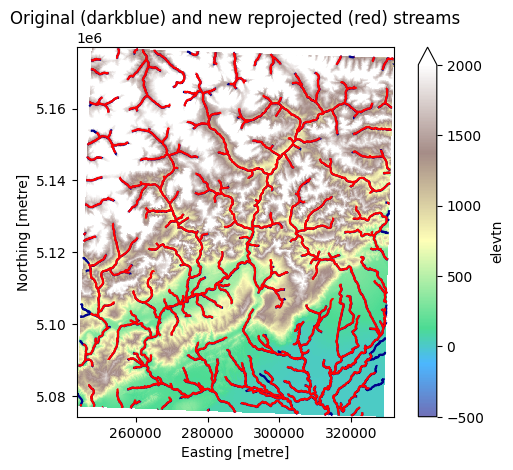

In [8]:
# reproject the elevation grid first
da_elv_reproj = ds["elevtn"].raster.reproject(dst_crs=utm)
# reproject the flow direction data
ds_reproj = hydromt.gis.flw.reproject_hydrography_like(
    ds,  # flow direction and upstream area grids
    da_elv=da_elv_reproj,  # destination grid
)
# parse it into a FlwdirRaster object
flwdir_reproj = hydromt.gis.flw.flwdir_from_da(ds_reproj["flwdir"], ftype="d8")
# derive streams based on a 10 km2 threshold
feats_reproj = flwdir_reproj.streams(mask=flwdir_reproj.upstream_area("km2") > 10)
gdf_riv_reproj = gpd.GeoDataFrame.from_features(feats_reproj, crs=ds_reproj.raster.crs)

# plot the streams from the reproject data (red) and compare with the original (darkblue)
# NOTE the different coordinates on the figure axis
ax = gdf_riv_reproj.plot(zorder=3, color="r")
gdf_riv.to_crs(utm).plot(ax=ax, zorder=2, color="darkblue")
da_elv_reproj.raster.mask_nodata().plot(
    cmap="terrain", ax=ax, vmin=-500, vmax=2000, alpha=0.7
)
ax.set_title("Original (darkblue) and new reprojected (red) streams")

## Upscale flow directions

Methods to upscale flow directions are required as models often have a coarser resolution than the elevation data used to build them. Instead of deriving flow directions from upscaled elevation data, it is better to directly upscale the flow direction data itself. The [upscale_flwdir()](../_generated/hydromt.gis.flw.upscale_flwdir.rst) method wraps a pyflwdir method that implements the recently developed Iterative Hydrography Upscaling (IHU) algorithm [(Eilander et al 2020)](https://hess.copernicus.org/articles/25/5287/2021/). Try different upscale factors and see the difference!

Text(0.5, 1.0, 'Original (darkblue) and new upscaled (red) streams')

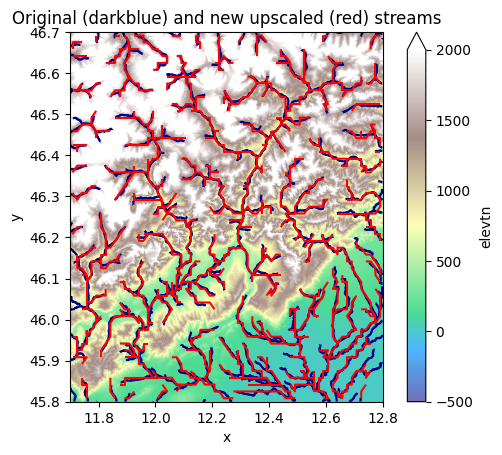

In [9]:
# upscale flow direction with a factor "scale_ratio"
# this returns both a flow direction grid and a new FlwdirRaster object
da_flw_lowres, flwdir_lowres = hydromt.gis.flw.upscale_flwdir(
    ds,  # flow direction and upstream area grids
    flwdir=flwdir,  # pyflwdir FlwdirRaster object
    scale_ratio=20,  # upscaling factor
)

# derive streams based on a 10 km2 threshold
feats_lowres = flwdir_lowres.streams(mask=flwdir_lowres.upstream_area("km2") > 10)
gdf_riv_lowres = gpd.GeoDataFrame.from_features(feats_lowres, crs=ds.raster.crs)

# plot the streams from the upscaled flow direction (red) and compare with the original (darkblue)
ax = gdf_riv_lowres.plot(zorder=3, color="r")
gdf_riv.plot(ax=ax, zorder=2, color="darkblue")
ds["elevtn"].raster.mask_nodata().plot(
    cmap="terrain", ax=ax, vmin=-500, vmax=2000, alpha=0.7
)
ax.set_title("Original (darkblue) and new upscaled (red) streams")